In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace
from scalebars import *

import balance_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
# %matplotlib notebook
%matplotlib widget
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

## TODO:
- update the synapses to enable poisson quantal input, as in the sac-sac model
- fill out notebook with figures and interactive displays

In [4]:
model_path = os.path.join(base_path, "model_runs")
save_name = "sac_net_rewrite"
load_name = None
# load_name = "control"
# load_name = "ttx"
# load_name = "ds_ach"
# load_name = "non_ds_ach"
# load_name = "fully_non_ds_ach"

model_config = configs.sac_mode_config(ttx=False, non_ds_ach=False, offset_ampa_ach=False, plexus=0)
# model_config["synprops"]["NMDA"]["pref_prob"] = 0.0
# model_config["synprops"]["NMDA"]["null_prob"] = 0.0

if load_name is None:
    from ei_balance_nogui import *
    os.makedirs(model_path, exist_ok=True)
    save_path = os.path.join(model_path, save_name) + ".h5"
    load_name = save_name
    exps.sacnet_run(
        save_path,
        model_config,
        n_nets=6,
        n_trials=3,
        rho_steps=[0.0, 1.0],
        # rho_steps=[1.0],
        pool_sz=6,
    )

hdf = h5.File(os.path.join(model_path, load_name) + ".h5", "r")
d = Workspace(hdf, read_only=True)
        
rhos = list(d.keys())
idxs = list(d[rhos[0]].keys())

sac net trials 1 to 6 (of 6)...
Done!


In [5]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            d.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [6]:
metrics = ana.get_sac_metrics(d)

dir_labels = d[rhos[0]][idxs[0]]["params"]["dir_labels"][:]
tuning = ana.analyze_tree(d, dir_labels, pref=0, thresh=-56)
sac_thetas = ana.get_sac_thetas(d)
sac_deltas = ana.get_sac_deltas(sac_thetas)

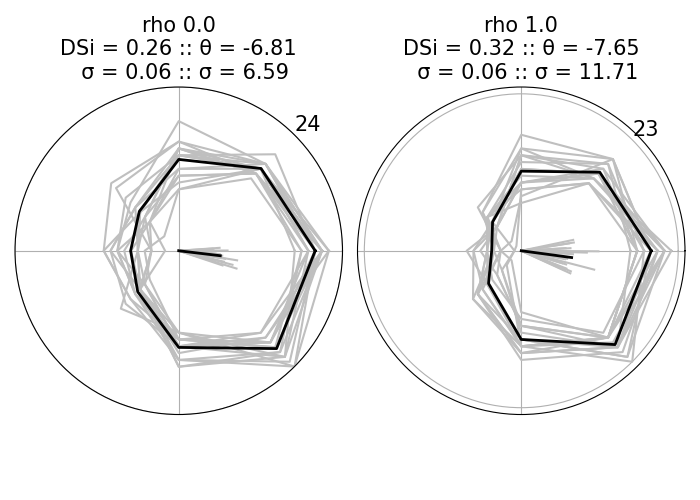

In [7]:
max_spikes = np.max([r["spikes"] for r in metrics.values()])
polar_fig = plt.figure(figsize=(7, 5))
n_cols = len(rhos)
polar_ax = [
    polar_plot(
        m,
        dir_labels,
        title="rho " + str(r),
        radius=max_spikes,
        net_shadows=False,
        save=False,
        fig=polar_fig,
        sub_loc=(1, n_cols, loc + 1),
    )
    for loc, (r, m) in enumerate(metrics.items())
]
polar_fig.tight_layout()

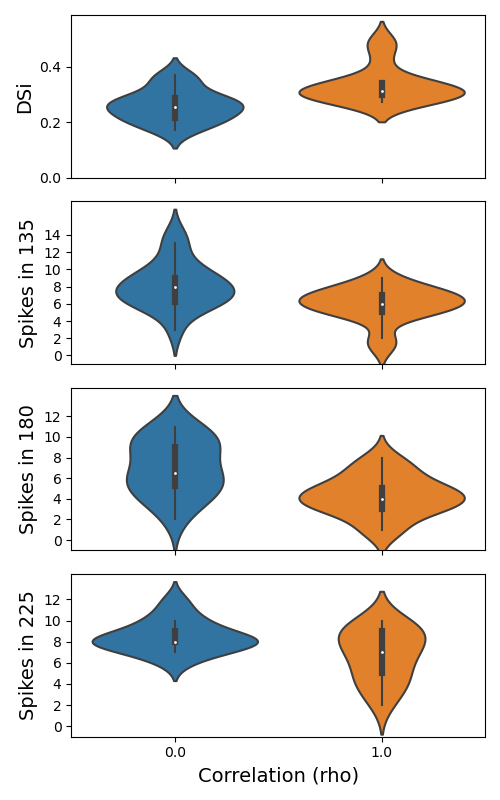

In [8]:
violins = sac_rho_violins(metrics, dir_labels, figsize=(5, 8))

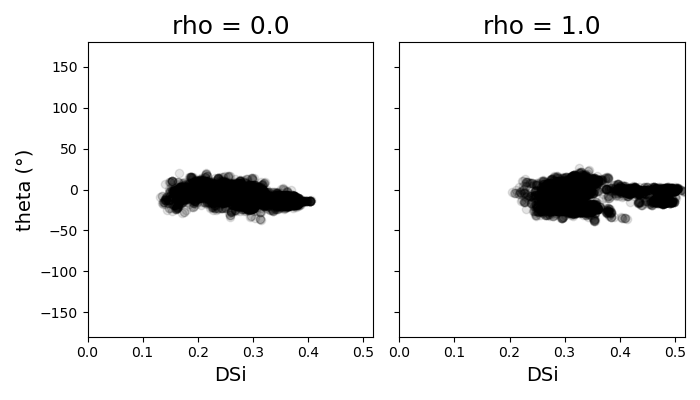

In [9]:
scatter_fig = ds_scatter(tuning, figsize=(7, 4))
scatter_fig.tight_layout()

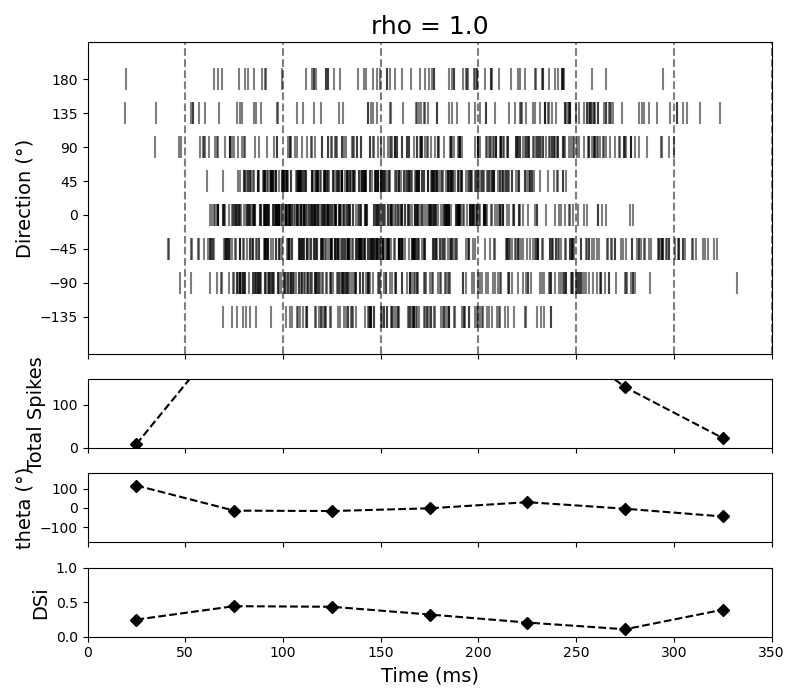

In [10]:
dir_field_offsets = [11.0, 18.8, 37.8, 13.8, 0.8, 19.3, 16.0, 0.0]  # ms
rasters_fig = spike_rasters(
    d,
    dir_labels,
    rho=1.,
    bin_ms=50,
    offsets=dir_field_offsets,
    colour="black",
    spike_vmax=160,
    figsize=(8, 7),
)

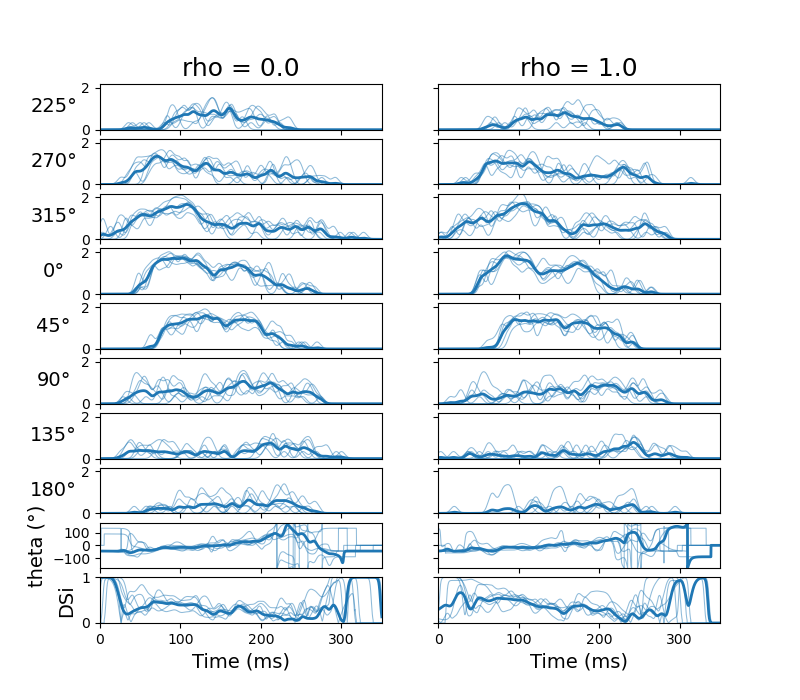

In [11]:
evol = time_evolution(d, dir_labels, kernel_var=45, figsize=(8, 7))

In [12]:
rho = 1.0
if d[rho][0]["params"]["soma_Na"] == 0.0:  # TTX condition
    rec_locs = d[rho][0]["dendrites"]["locs"]
    syn_locs = d[rho][0]["syn_locs"]
    syn_rec_lookups = get_syn_rec_lookups(rec_locs, syn_locs)
    post_syn_avg_tuning = get_postsyn_avg_tuning(tuning, syn_rec_lookups)
    theta_diffs = plot_theta_diff_tuning_scatters(post_syn_avg_tuning, sac_deltas, rhos=[rho])
    theta_diff_bins = plot_theta_diff_vs_abs_theta(post_syn_avg_tuning, sac_deltas, rhos=[rho])

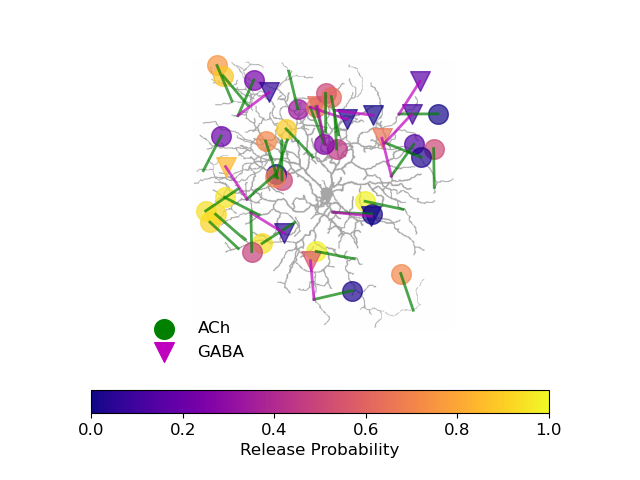

In [13]:
rho = 0.0
net = 0

over_fig, over_ax = plt.subplots(1)
ana.plot_dends_overlay(
    over_fig,
    over_ax,
    d[rho][net]["syn_locs"],
    d[rho][net]["sac_net"]["wiring"]["bp_locs"],
    d[rho][net]["sac_net"]["wiring"]["probs"],
    dir_labels,
    stim_angle=0,
    n_syn=30,
    sac_thickness=2,
    sac_marker_size=200,
    syn_choice_seed=6,
)
#6 26 37
over_fig.tight_layout()

Average GABA synapse count: 143.68


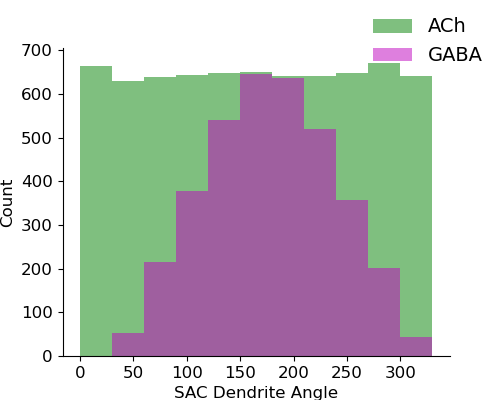

In [14]:
conf = copy.deepcopy(model_config)
conf["seed"] = 4
angle_dist_fig, angle_dist_ax = ana.sac_angle_distribution(
    conf, n_nets=25, bins=[12], incl_yticks=True, figsize=(5, 4))

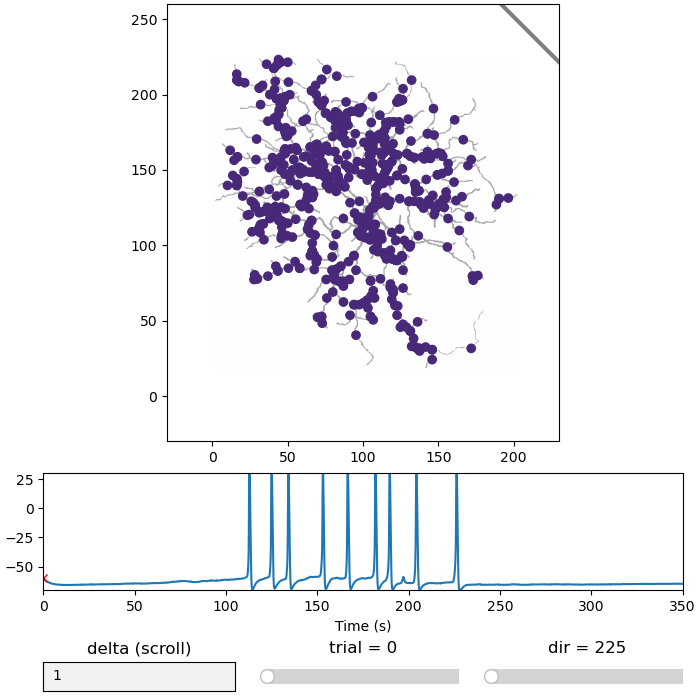

In [15]:
# mr = MotionResponse(d[0.0][0], tree_k="Vm", figsize=(7, 7))
mr = MotionResponse(d[1.0][0], tree_k="Vm", figsize=(7, 7))

In [16]:
close_button()